# Autoencoder

## Preparations
### Load libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

2025-02-20 05:09:12.493614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740028152.512403   11168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740028152.518042   11168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 05:09:12.540422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pickle

In [4]:
tf.random.set_seed(123)
np.random.seed(123)

### Prepare data

In [5]:
# Load data:
mnist = tf.keras.datasets.mnist
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

# Scale image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                      test_size=0.20, random_state=42)

In [6]:
train_val_label_df = pd.DataFrame(train_val_labels)
train_val_label_df.columns = ['label']
train_val_label_df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [7]:
val_label_df = pd.DataFrame(val_labels)
val_label_df.columns = ['label']
val_label_df['label'].value_counts(sort=False, ascending=True)

label
7    1299
3    1219
8    1160
9    1194
5    1104
4    1176
2    1174
6    1177
1    1322
0    1175
Name: count, dtype: int64

In [8]:
train_from_scratch = True

## The Autoencoder
Every autoencoder consists of two parts: an encoder and a decoder.

* The **encoder** receives the original data (in our case, the black and white images) as input and generates a lower-dimensional code from it.
* The **decoder** receives the code and decodes it into original data (e.g. the images) in the same format as the encoder's inputs.

### Model definition

The two parts put together form the autoencoder:

**Comments on activation functions:**

***Why ReLU?***

* Simplicity and Efficiency: ReLU (Rectified Linear Unit) is computationally efficient because it involves simple thresholding at zero. This makes it faster to compute compared to other activation functions.
* Sparse Activation: ReLU promotes sparsity in the network by setting negative values to zero, which can help in learning more robust features.
* Gradient Propagation: ReLU helps mitigate the vanishing gradient problem, allowing gradients to propagate more effectively during backpropagation.

***Why Not SELU?***

SELU (Scaled Exponential Linear Unit) is another excellent activation function, especially for self-normalizing neural networks. However, SELU requires careful initialization and specific network architecture (e.g., no Batch Normalization) to maintain its self-normalizing properties. For a straightforward convolutional autoencoder, ReLU is often preferred due to its simplicity and effectiveness.

***Sigmoid*** at the end to get an output between 0 and 1.

In [9]:
mnist_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu')
])

mnist_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (100,)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae = tf.keras.Sequential([mnist_encoder, mnist_decoder])

I0000 00:00:1740028155.044385   11168 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18337 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.20gb, pci bus id: 0000:00:05.0, compute capability: 8.0


### Training
The autoencoder uses unsupervised learning, i.e. we do not pass any predefined labels or similar. Instead, the output should be as similar as possible to the input. We use the squared error as a measure of the quality of the reconstruction.

For a start, we allow a maximum of 10 epochs to train - as with the other convolutional networks (and with deep neural networks in general), you should allow significantly more epochs for real applications.

The training takes a little longer here... With the following code you can save and reload the learned weights - just set `train_from_scratch` as needed.
Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [10]:
# compile and fit the model
tf.random.set_seed(42) 
mnist_ae.compile(loss="mse", optimizer="nadam")

In [11]:
nEpochs = 50
nPatience = 5

# define paths:
encoder_weights_path = './mnist_encoder.weights.h5'
decoder_weights_path = './mnist_decoder.weights.h5'
history_path = './mnist_ae.history.h5'


train_from_scratch = True
if train_from_scratch:
    history_ae = mnist_ae.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                       callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience, 
                                                   verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder.save_weights(encoder_weights_path)
    mnist_decoder.save_weights(decoder_weights_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_ae, f)

else:
    # load previously computed weights
    fashion_encoder.load_weights(encoder_weights_path)
    fashion_decoder.load_weights(decoder_weights_path)

    # load history:
    with open(history_path, 'rb') as f:
        history_ae = pickle.load(f)

Epoch 1/50


I0000 00:00:1740028157.364152   11214 service.cc:148] XLA service 0x7f6274005720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740028157.364197   11214 service.cc:156]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.20gb, Compute Capability 8.0
2025-02-20 05:09:17.422061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740028157.509433   11214 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-20 05:09:18.678130: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_363', 540 bytes spill stores, 544 bytes spill loads

2025-02-20 05:09:19.306805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_501'

  67/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1160

I0000 00:00:1740028163.348840   11214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0322 - val_loss: 0.0071
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 12/50
1500/1500 ━━━━━━━━━━━━━━━━━━

In [12]:
def plot_history(history):
    """
    Plot model training history.
    Args:
    - history: tensorflow history object.

    Returns:
    None
    """
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.legend()
    plt.xlabel('Loss history')
    plt.ylabel('Loss')

    plt.show()

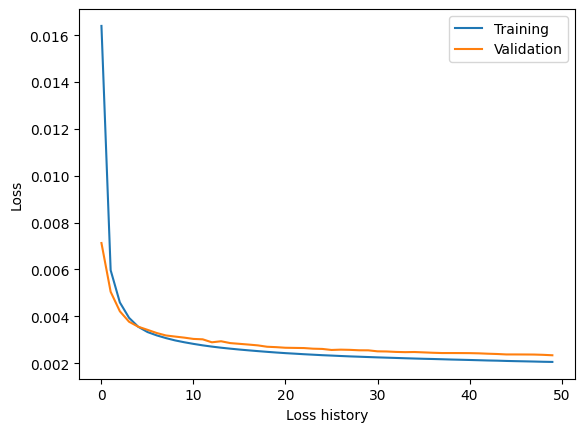

In [13]:
plot_history(history_ae.history)

### Model Summary
We can now get a summary of the model:

In [14]:
mnist_ae.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 100)            │       265,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       266,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,655 (6.09 MB)

 Trainable params: 531,884 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,063,771 (4.06 MB)

In [15]:
mnist_encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,600 (1.01 MB)

 Trainable params: 265,600 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
mnist_decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 300)            │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       235,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,284 (1.02 MB)

 Trainable params: 266,284 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### Looking at the reconstructions
Let's look at some of the reconstructed images:

In [17]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=test_images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

2025-02-20 05:13:02.889967: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 300 bytes spill stores, 360 bytes spill loads

2025-02-20 05:13:03.446555: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 300 bytes spill stores, 360 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


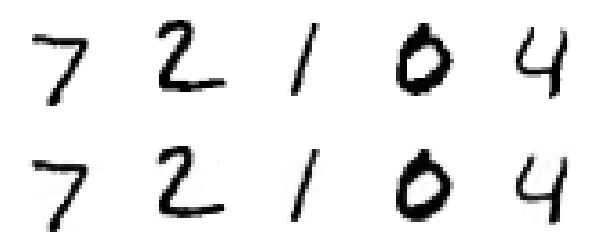

In [18]:
show_reconstructions(mnist_ae)

## Sparse Autoencoders

### Encoding Dimension 30

In [19]:
mnist_encoder_sparse30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

mnist_decoder_sparse30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (30,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse30 = tf.keras.Sequential([mnist_encoder_sparse30, mnist_decoder_sparse30])
mnist_ae_sparse30.compile(loss="mse", optimizer="nadam")

In [21]:
# define paths:
mnist_encoder_sparse30_path = './mnist_encoder_sparse30.weights.h5'
mnist_decoder_sparse30_path = './mnist_decoder_sparse30.weights.h5'
history_path = './mnist_decoder_sparse30.history.h5'

if train_from_scratch:
    history30 = mnist_ae_sparse30.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse30.save_weights(mnist_encoder_sparse30_path)
    mnist_decoder_sparse30.save_weights(mnist_decoder_sparse30_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history30, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse30.load_weights(mnist_encoder_sparse30_path)
    mnist_decoder_sparse30.load_weights(mnist_decoder_sparse30_path)

    # load history:
    with open(history_path, 'rb') as f:
        history30 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0405 - val_loss: 0.0149
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0116
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 12/50
1500/1500 ━━━━━━━

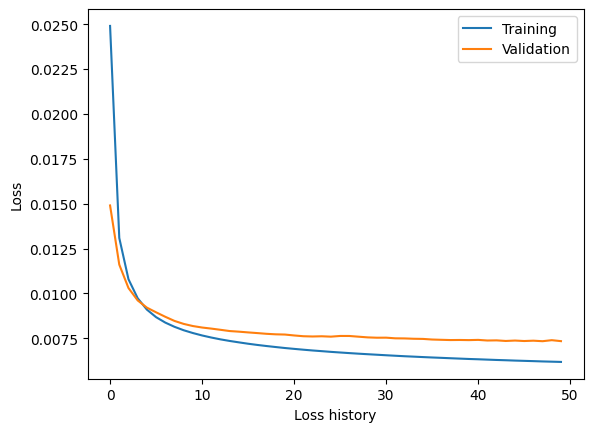

In [22]:
plot_history(history30.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


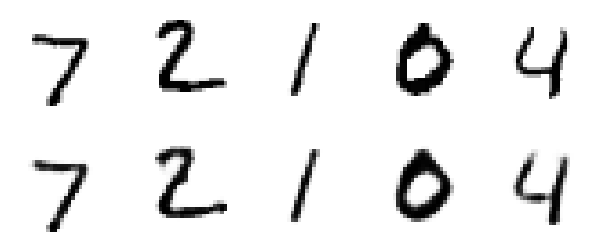

In [23]:
show_reconstructions(mnist_ae_sparse30)

### Encoding Dimension 5

In [24]:
mnist_encoder_sparse5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu')
])

mnist_decoder_sparse5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (5,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse5 = tf.keras.Sequential([mnist_encoder_sparse5, mnist_decoder_sparse5])
mnist_ae_sparse5.compile(loss="mse", optimizer="nadam")

In [25]:
# define paths:
mnist_encoder_sparse5_path = './mnist_encoder_sparse5.weights.h5'
mnist_decoder_sparse5_path = './mnist_decoder_sparse5.weights.h5'
history_path = './mnist_decoder_sparse5.history.h5'

if train_from_scratch:
    history5 = mnist_ae_sparse5.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse5.save_weights(mnist_encoder_sparse5_path)
    mnist_decoder_sparse5.save_weights(mnist_decoder_sparse5_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history5, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse5.load_weights(mnist_encoder_sparse5_path)
    mnist_decoder_sparse5.load_weights(mnist_decoder_sparse5_path)

    # load history:
    with open(history_path, 'rb') as f:
        history5 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0534 - val_loss: 0.0315
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0307 - val_loss: 0.0286
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0281 - val_loss: 0.0270
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0266 - val_loss: 0.0261
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0256 - val_loss: 0.0254
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0248 - val_loss: 0.0249
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0238 - val_loss: 0.0243
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0230 - val_loss: 0.0238
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0227 - val_loss: 0.0236
Epoch 12/50
1500/1500 ━━━━━━━

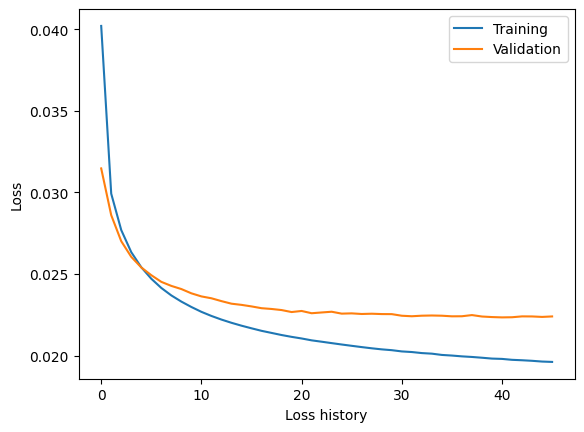

In [26]:
plot_history(history5.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


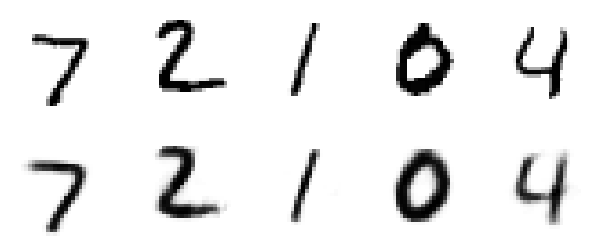

In [27]:
show_reconstructions(mnist_ae_sparse5)

### Encoding Dimension 2

In [42]:
# Model definition
mnist_encoder_sparse2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu')
])

mnist_decoder_sparse2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (2,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse2 = tf.keras.Sequential([mnist_encoder_sparse2, mnist_decoder_sparse2])

tf.random.set_seed(42) 
mnist_ae_sparse2.compile(loss="mse", optimizer="nadam")

In [43]:
# define paths:
mnist_encoder_sparse2_path = './mnist_encoder_sparse2.weights.h5'
mnist_decoder_sparse2_path = './mnist_decoder_sparse2.weights.h5'
history_path = './mnist_decoder_sparse2.history.h5'

# Train if needed:
if train_from_scratch:
    history2 = mnist_ae_sparse2.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse2.save_weights(mnist_encoder_sparse2_path)
    mnist_decoder_sparse2.save_weights(mnist_decoder_sparse2_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history2, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse2.load_weights(mnist_encoder_sparse2_path)
    mnist_decoder_sparse2.load_weights(mnist_decoder_sparse2_path)

    # load history:
    with open(history_path, 'rb') as f:
        history2 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0636 - val_loss: 0.0453
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0442 - val_loss: 0.0419
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0415 - val_loss: 0.0405
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0402 - val_loss: 0.0397
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0394 - val_loss: 0.0392
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0388 - val_loss: 0.0387
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0383 - val_loss: 0.0388
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0378 - val_loss: 0.0379
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0375 - val_loss: 0.0375
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0371 - val_loss: 0.0374
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0369 - val_loss: 0.0376
Epoch 12/50
1500/1500 ━━━━━━━

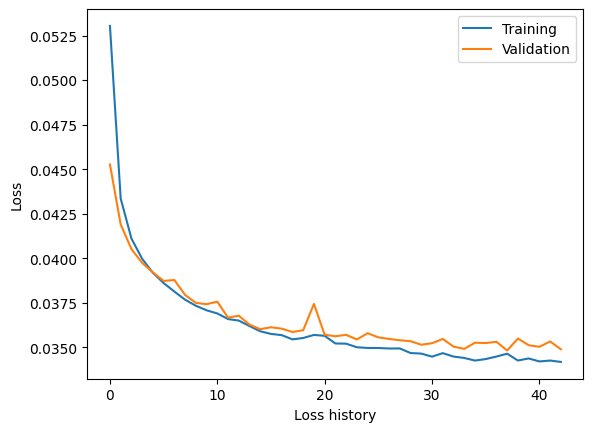

In [44]:
plot_history(history2.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


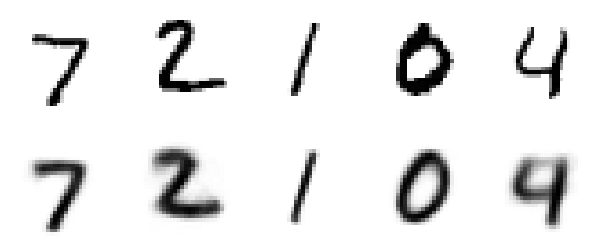

In [45]:
show_reconstructions(mnist_ae_sparse2)

### Visualizing the Digits in 2D
Since we only have 2 dimensions as "code", we can nicely visualize the representation of the individual digits. To do so, we just pass them through the encoder to get the encodings:

In [46]:
val_encodings_2D = mnist_encoder_sparse2(val_images)
val_encodings_2D.shape

TensorShape([12000, 2])

In [47]:
val_encodings_2D[:10,:]

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[109.854294 ,  80.95926  ],
       [  2.5817816,   3.7445812],
       [  6.5794234,   3.8206217],
       [ 36.56871  ,  20.28021  ],
       [  3.2907863,   4.329571 ],
       [ 27.124273 ,  20.130169 ],
       [ 66.60619  ,  47.531223 ],
       [ 63.052147 ,  45.707115 ],
       [  1.389105 ,   2.7424061],
       [ 37.066498 ,  30.28605  ]], dtype=float32)>

For nicer visualisation, we create a data frame, consisting of both dimensions and the label. We then use the label (i.e., the digit represented by the image) to color the individual representations in 2D:

In [48]:
sparseAE_embedding = pd.DataFrame(val_encodings_2D)
sparseAE_embedding.columns = ['Dimension 1', 'Dimension 2']
sparseAE_embedding['label'] = val_labels

In [49]:
sparseAE_embedding.shape

(12000, 3)

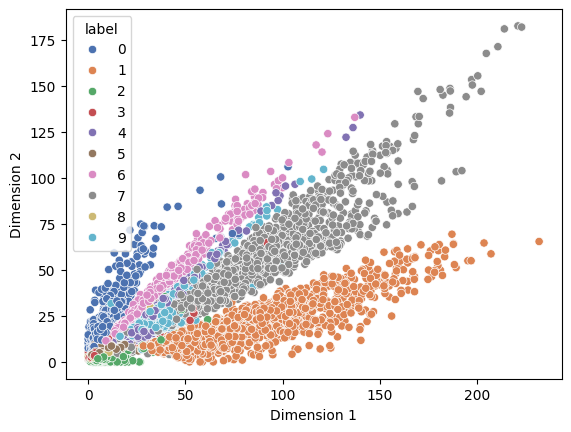

In [50]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.show()

We also do a plot on logarithmic scale so we can better see the digits that are more concentraged in the encoding space:

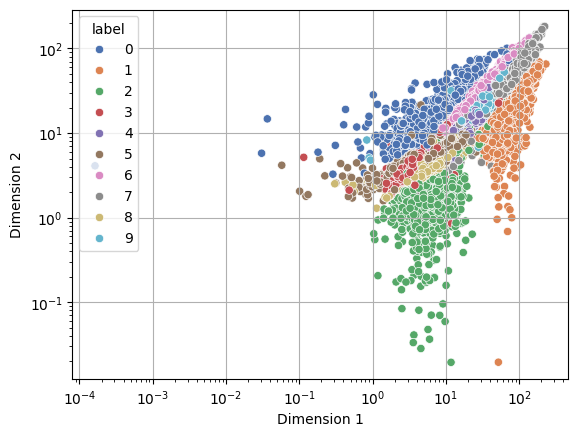

In [51]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

### Generating outputs
So far we have used the encoder to encode a digit image an 2D. Now we will use the decoder to decode a code (i.e., a list of 2 elements) to a full image.

**Exercise:** Using the visualisations above, can you predict which inputs will be decoded to images representing which digits? Read off the x- and y-coordinates of a point, and use the color code to determine the expected digit it will represent.
Use the code below to check your finding!

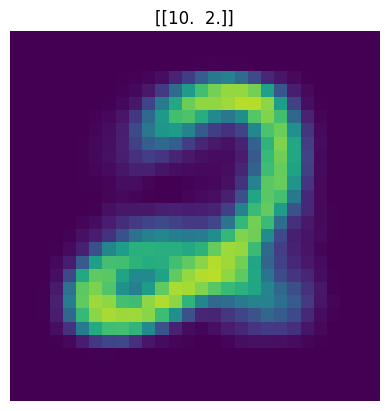

In [52]:
code = np.zeros(shape=[1, 2])
# modify the values of the first and second dimension
code[0, 0] = 10
code[0, 1] = 2
coding = np.squeeze(mnist_decoder_sparse2(code))
plt.imshow(coding, vmin=0, vmax=1)
plt.axis('off')
plt.title(code)
plt.show()

**Solution:** 

* (0, 0) will represent a 0.
* (10, 2) will represent a 2.
* etc.

**(End of Solution)**

## Visualizing Outputs for Several Inputs

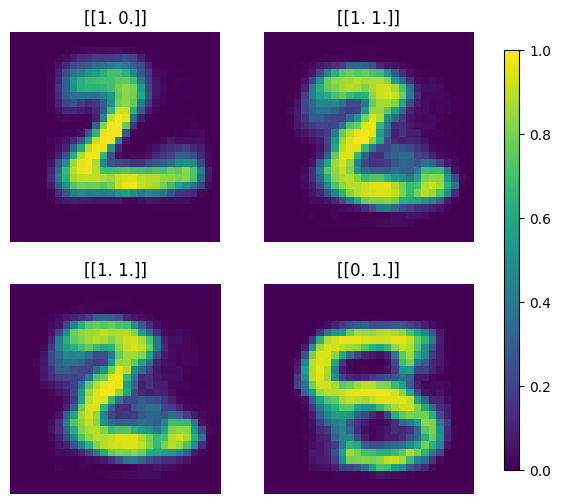

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ID1 in range(2):
    for ID2 in range(2):
        code = np.zeros(shape=[1, 2])
        code[0, ID1] = 1
        code[0, ID2] = 1
        coding = np.squeeze(mnist_decoder_sparse2(code))
        im = axs[ID1, ID2].imshow(coding, vmin=0, vmax=1)
        axs[ID1, ID2].axis('off')
        axs[ID1, ID2].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

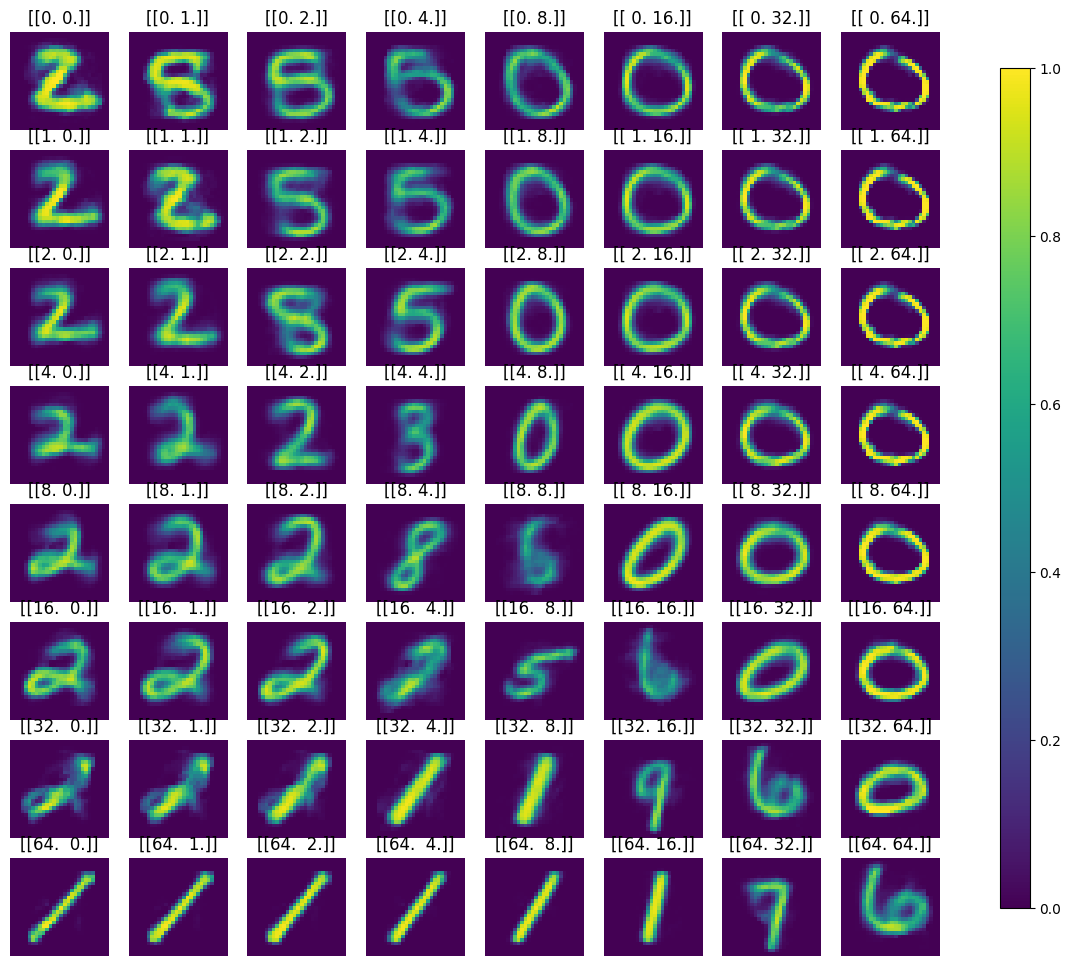

In [54]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))

for val1 in np.linspace(0, 7, 8):
    for val2 in np.linspace(0, 7, 8):
        code = np.zeros(shape=[1, 2])
        if val1>0:
            code[0, 0] = 2**(val1-1)
        if val2>0:
            code[0, 1] = 2**(val2-1)
        coding = np.squeeze(mnist_decoder_sparse2(code))
        im = axs[int(val1), int(val2)].imshow(coding, vmin=0, vmax=1)
        axs[int(val1), int(val2)].axis('off')
        axs[int(val1), int(val2)].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Denoising Autoencoders

### Generate Noisy Data

In [55]:
def add_noise(image_array, noise_factor=0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = (1-noise_factor) * image_array + noise_factor * np.random.random(size=image_array.shape)
    return noisy_array

In [56]:
from sklearn.decomposition import PCA

# Add noise:
# - to training images
train_images_noisy = add_noise(train_images)

# - to validation images
val_images_noisy = add_noise(val_images)

# - to test images
test_images_noisy = add_noise(test_images)

# flatten images:
train_images_noisy_flat = train_images_noisy.reshape(train_images_noisy.shape[0], -1)
val_images_noisy_flat = val_images_noisy.reshape(val_images_noisy.shape[0], -1)
test_images_noisy_flat = test_images_noisy.reshape(test_images_noisy.shape[0], -1)

### Denoising with PCA

In [57]:
# Apply PCA to reduce to 32 components
pca = PCA(n_components=32, random_state=42)
pca.fit(test_images_noisy_flat)

PCA(n_components=32, random_state=42)

In [58]:
reconstructed_pca = pca.inverse_transform(pca.transform(test_images_noisy_flat))

In [59]:
import matplotlib.pyplot as plt

def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    plt.show()

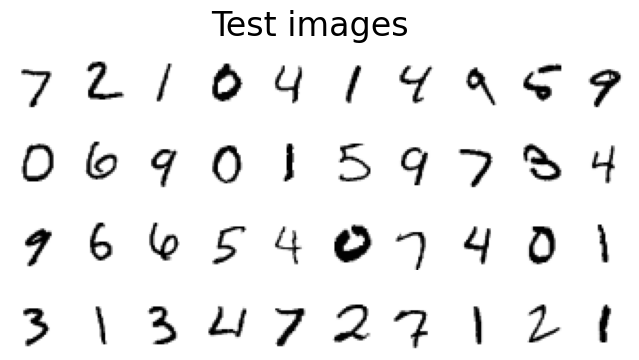

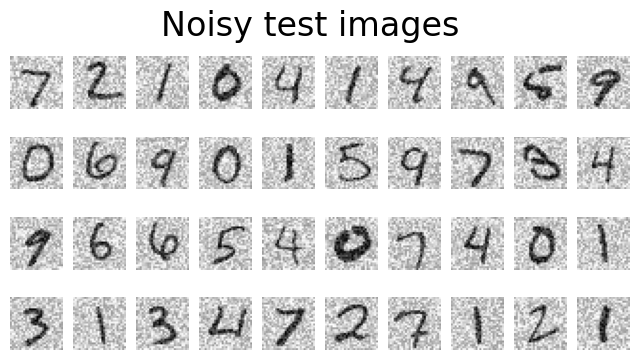

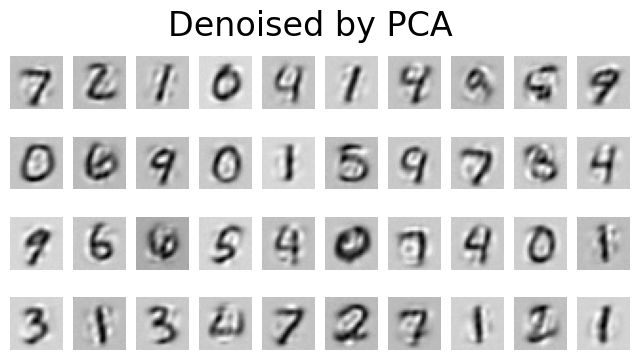

In [60]:
# Visualize the PCA results
plot_digits(test_images, "Test images")
plot_digits(test_images_noisy, "Noisy test images")
plot_digits(reconstructed_pca, "Denoised by PCA")


### Denoising with AE

In [61]:
mnist_encoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

mnist_decoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (30,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_denoise = tf.keras.Sequential([mnist_encoder_denoise, mnist_decoder_denoise])
mnist_ae_denoise.compile(loss="mse", optimizer="nadam")

In [62]:
# define paths:
mnist_encoder_denoise_path = './mnist_encoder_denoise.weights.h5'
mnist_decoder_denoise_path = './mnist_decoder_denoise.weights.h5'
history_path = './mnist_decoder_denoise.history.h5'

if train_from_scratch:
    history_denoise  = mnist_ae_denoise.fit(train_images_noisy, train_images, epochs=nEpochs, validation_data=(val_images_noisy, val_images),
                                           callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                       verbose=False, restore_best_weights=True)])
                                       
    # Save the weights:
    mnist_encoder_denoise.save_weights(mnist_encoder_denoise_path)
    mnist_decoder_denoise.save_weights(mnist_decoder_denoise_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise, f)

else:
    # load previsously computed weights
    mnist_encoder_denoise.load_weights(mnist_encoder_denoise_path)
    mnist_decoder_denoise.load_weights(mnist_decoder_denoise_path)

    # load history:
    with open(history_path, 'rb') as f:
        history_denoise = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0474 - val_loss: 0.0221
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0206 - val_loss: 0.0181
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0175 - val_loss: 0.0165
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0126 - val_loss: 0.0132
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0123 - val_loss: 0.0130
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0120 - val_loss: 0.0128
Epoch 12/50
1500/1500 ━━━━━━━━

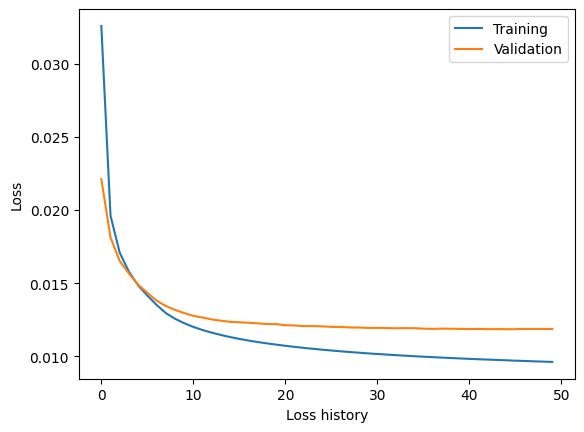

In [63]:
plot_history(history_denoise.history)

In [64]:
reconstructed_ae = mnist_ae_denoise(test_images_noisy)

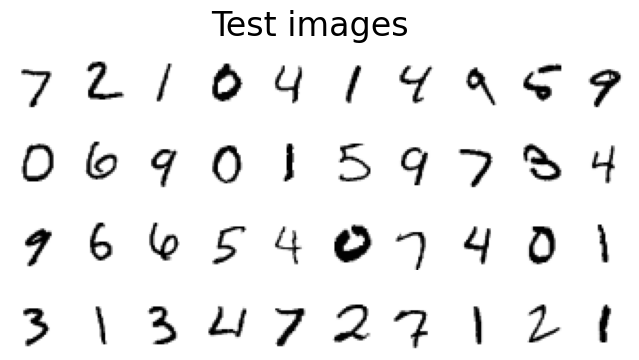

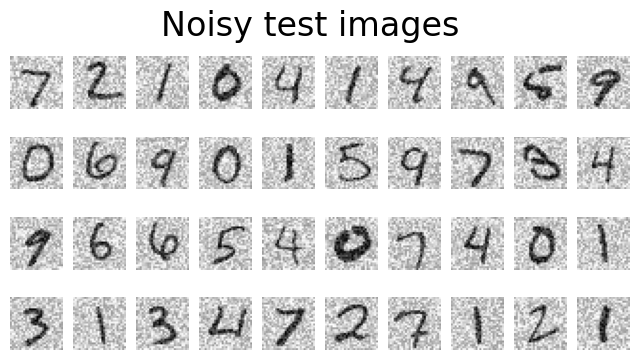

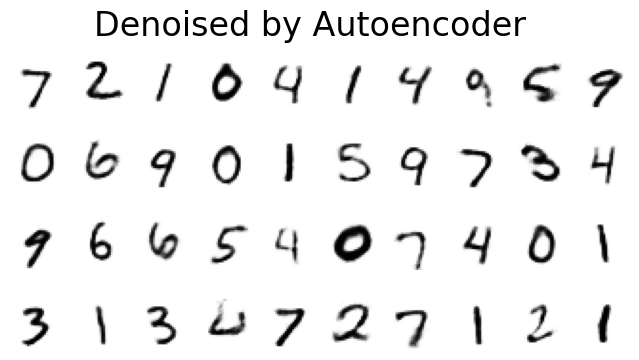

In [65]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_noisy, "Noisy test images")
plot_digits(reconstructed_ae.numpy(), "Denoised by Autoencoder")

## Autoencoder based on Convolutions
Below is the definition of a very simple autoencoder:

In [66]:
CNNmnist_simple_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
])

CNNmnist_simple_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (14, 14, 32)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_simple_ae = tf.keras.Sequential([CNNmnist_simple_encoder, CNNmnist_simple_decoder])

**Exercise:** Using inspiration from the commands above, compile and train this autoencoder. Start with 10 epochs, you can always extend the training later. It's probably easiest if you save this notebook under a new name, and then work through it again using CNN layers.

Compare the number of parameters and the results with the autoencoder based on the densely connected layers (i.e., without convolutions). What do you observe?

**Solution:** see separate notebook.